# <center>${\textbf{Intrusion Detection System}}$</center>


${\textbf{Importing Libraries}}$

In [1]:
import warnings
warnings.simplefilter("ignore")
import pickle
import os
import datetime
from IPython.display import Image

In [2]:
import numpy as np
import pandas as pd
import pandas_profiling as pp

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
import xgboost as xgb

In [7]:
from sklearn.metrics import auc,roc_auc_score,confusion_matrix,accuracy_score,classification_report,roc_curve
from sklearn.metrics import mean_squared_error

In [8]:
from sklearn.cluster import KMeans

In [10]:
np.random.seed(123)
pd.set_option('display.max_columns', None)
data_path = './data/kddcup.data.corrected'

<center>${\textbf{Data OverView}}$<center> 


In [11]:
col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
             "num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
             "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
             "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
             "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
             "dst_host_srv_rerror_rate","label"]
KDD99 =  pd.read_csv(data_path, header=None,names=col_names)

In [12]:
print(KDD99.shape)
KDD99.info()

(4898431, 42)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898431 entries, 0 to 4898430
Data columns (total 42 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   duration                     int64  
 1   protocol_type                object 
 2   service                      object 
 3   flag                         object 
 4   src_bytes                    int64  
 5   dst_bytes                    int64  
 6   land                         int64  
 7   wrong_fragment               int64  
 8   urgent                       int64  
 9   hot                          int64  
 10  num_failed_logins            int64  
 11  logged_in                    int64  
 12  num_compromised              int64  
 13  root_shell                   int64  
 14  su_attempted                 int64  
 15  num_root                     int64  
 16  num_file_creations           int64  
 17  num_shells                   int64  
 18  num_access_files            

${\textbf{Data Set Information: }}$
This is the data set used for The Third International Knowledge Discovery and Data Mining Tools Competition, which was held in conjunction with KDD-99 The Fifth International Conference on Knowledge Discovery and Data Mining. The competition task was to build a network intrusion detector, a predictive model capable of distinguishing between "bad" connections, called intrusions or attacks, and "good" normal connections. This database contains a standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment.

Each row of the KDD Cup 99 dataset represents a network connection, with 41 independent variables and 1 dependent variable. The independent variables can be divided into three categories:
1. Basic network connection input characteristics such as duration, protocol type, and number of bytes from source IP addresses
2. Network connection content input features
3. Over a time window, the statistical input features are computed.

${\textbf{Attribute Information: }}$
1. duration: duration of connection in seconds
2. protocoll_type: connection protocol (tcp,udp,icmp)
3. service: dst port mapped to service (http,ftp,...)
4. flag: normal or error status flag of connection
5. src_bytes: number of data bytes from src to dst
6. dst_bytes: number of data bytes from dst to src
7. land: 1 if connection is from/to the same host/port else 0
8. wrong_fragment: number of 'wrong' fragments (0,1,3)
9. urgent: number of urgent packets
10. hot: number of hot indicators(bro-ids feature)
11. num_failed_logins: number of failed login attempts
12. logged_in: 1 if succefully logged in else 0
13. num_compromised: number of compromised condtions
14. root_shell: 1 if root shell obtained else 0
15. su_attempted: 1  if root mood attempted else 0
16. num_root: number of root accesses
17. num_file_creations: number of file creation operations
18. num_shells: number of shell prompts
19. num_access_files:  number of operations on access control files
20. num_outbound_cmds:  number of outbound commands in an ftp session
21. is_host_login:  1 if login belongs to hot list(root,admin) else 0
22. is_guest_login: 1 if login is guest else 0
23. count: number of connections to the same host as current connection in past 2 seconds
24. srv_count: number of connections to the same service as current connection in past 2 seconds
25. serror_rate: % of connections that 'SYN' errors
26. srv_serror_rate:% of connections that gave 'syn' errors in server
27. rerror_rate: % of connection that have 'REJ' errors
28. srv_rerror_rate: % of connection that have 'REJ' errors in server
29. same_srv_rate: % of connection to the same service
30. diff_srv_rate: % of connection to different service
31. srv_diff_host_rate: %of connection to different host
32. dst_host_count: count of connections having same dst host
33. dst_host_srv_count: count of connections having same dst host and using same service
34. dst_host_same_srv_rate: % of connections having same dst host and using same service
35. dst_host_diff_srv_rate: % of differennt service on current host
36. dst_host_same_src_port_rate: % of connections to current host having same src port
37. dst_host_srv_diff_host_rate: % of connections to same service coming from diff hosts
38. dst_host_serror_rate: % of connection the current host that have an S0 error
39. dst_host_srv_serror_rate: %of connections to current host and specified service that have an S0 errot
40. dst_host_rerror_rate: % of connections to current host that have an RST error
41. dst_host_srv_rerror_rate: % of connections to current host and specified service that have and RST error
42. label: connection type

In [13]:
KDD99.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [14]:
KDD99.tail()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
4898426,0,tcp,http,SF,212,2288,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,32,0.0,0.0,0.0,0.0,1.0,0.0,0.16,3,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,normal.
4898427,0,tcp,http,SF,219,236,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,33,0.0,0.0,0.0,0.0,1.0,0.0,0.15,4,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,normal.
4898428,0,tcp,http,SF,218,3610,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,34,0.0,0.0,0.0,0.0,1.0,0.0,0.15,5,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,normal.
4898429,0,tcp,http,SF,219,1234,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,35,0.0,0.0,0.0,0.0,1.0,0.0,0.14,6,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,normal.
4898430,0,tcp,http,SF,219,1098,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,7,255,1.0,0.0,0.14,0.05,0.0,0.01,0.0,0.0,normal.


In [15]:
attacks_types = KDD99["label"].unique()
print(attacks_types)
KDD99["label"].value_counts()

['normal.' 'buffer_overflow.' 'loadmodule.' 'perl.' 'neptune.' 'smurf.'
 'guess_passwd.' 'pod.' 'teardrop.' 'portsweep.' 'ipsweep.' 'land.'
 'ftp_write.' 'back.' 'imap.' 'satan.' 'phf.' 'nmap.' 'multihop.'
 'warezmaster.' 'warezclient.' 'spy.' 'rootkit.']


smurf.              2807886
neptune.            1072017
normal.              972781
satan.                15892
ipsweep.              12481
portsweep.            10413
nmap.                  2316
back.                  2203
warezclient.           1020
teardrop.               979
pod.                    264
guess_passwd.            53
buffer_overflow.         30
land.                    21
warezmaster.             20
imap.                    12
rootkit.                 10
loadmodule.               9
ftp_write.                8
multihop.                 7
phf.                      4
perl.                     3
spy.                      2
Name: label, dtype: int64

<AxesSubplot:>

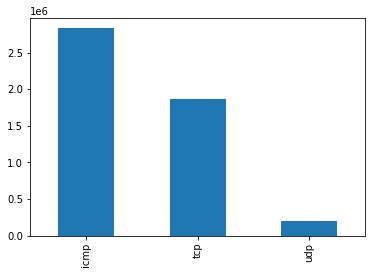

In [16]:
KDD99.protocol_type.value_counts().plot(kind="bar")

<AxesSubplot:>

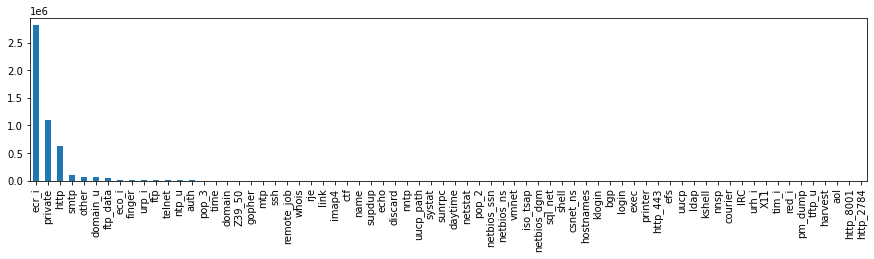

In [17]:
plt.figure(figsize=(15,3))
KDD99.service.value_counts().plot(kind="bar")

<AxesSubplot:>

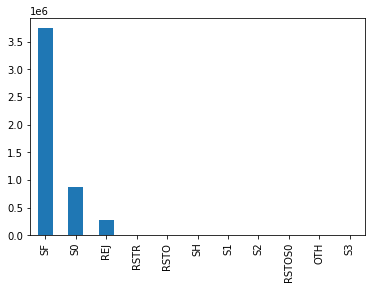

In [18]:
KDD99.flag.value_counts().plot(kind="bar")

<AxesSubplot:>

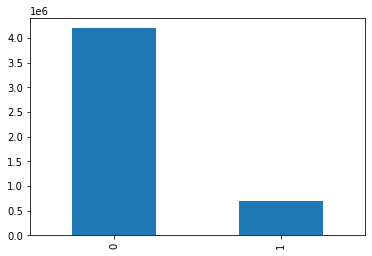

In [19]:
KDD99.logged_in.value_counts().plot(kind="bar")

<AxesSubplot:>

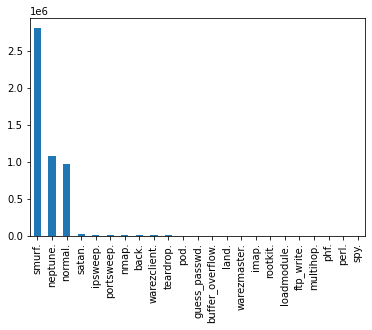

In [20]:
KDD99.label.value_counts().plot(kind="bar")

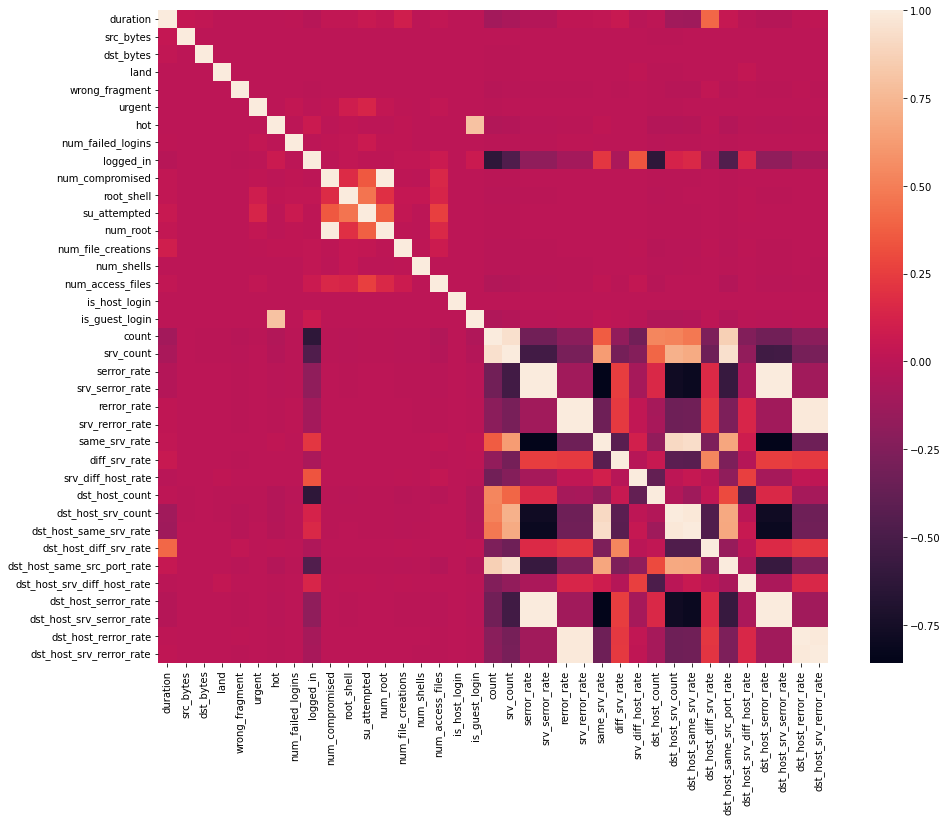

In [21]:
# drop columns with NaN
df = KDD99.dropna('columns')
# keep columns where there are more than 1 unique values
df = df[[col for col in df if df[col].nunique() > 1]]
corr = df.corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr)
plt.show()

<center>${\textbf{Data PreProcessing}}$<center>

In [22]:
# here we train a label encoder so that we can map our classes to integers later for model training
le = LabelEncoder()
le.fit(df.label)
print(le.classes_)

['back.' 'buffer_overflow.' 'ftp_write.' 'guess_passwd.' 'imap.'
 'ipsweep.' 'land.' 'loadmodule.' 'multihop.' 'neptune.' 'nmap.' 'normal.'
 'perl.' 'phf.' 'pod.' 'portsweep.' 'rootkit.' 'satan.' 'smurf.' 'spy.'
 'teardrop.' 'warezclient.' 'warezmaster.']


One-hot encoding will transform the categorical variable into a numerical variable for each category. If a category takes ten values, then that categorical variable will be transformed into 10 numerical variables.

We will use one-hot encoding to translate each of the 7 categorical features: protocol type, service, flag, land, logged_in, is_host_login, is_guest_login

In [23]:
# capture the categorical variables and one-hot encode them
categoicals = ['protocol_type', 'service', 'flag', 'land', 'logged_in','is_host_login', 'is_guest_login']
# find unique labels for each category
categoical_data = pd.get_dummies(df[categoicals])
# check that the categorical variables were created correctly
categoical_data.head()

,land,logged_in,is_host_login,is_guest_login,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [24]:
numericals = list(set(df.columns.values.tolist()) - set(categoicals))
numericals.remove('label')
numerical_data = df[numericals].copy()
# check that the numeric data has been captured accurately
numerical_data.head()

,dst_host_rerror_rate,num_file_creations,wrong_fragment,root_shell,count,srv_count,srv_diff_host_rate,same_srv_rate,dst_host_srv_count,dst_host_serror_rate,num_compromised,hot,num_failed_logins,dst_host_same_src_port_rate,su_attempted,dst_host_srv_serror_rate,srv_rerror_rate,num_root,num_access_files,num_shells,dst_bytes,dst_host_count,dst_host_diff_srv_rate,urgent,srv_serror_rate,dst_host_same_srv_rate,dst_host_srv_diff_host_rate,serror_rate,dst_host_srv_rerror_rate,rerror_rate,duration,src_bytes,diff_srv_rate
0,0.0,0,0,0,1,1,0.0,1.0,0,0.0,0,0,0,0.00,0,0.0,0.0,0,0,0,45076,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,215,0.0
1,0.0,0,0,0,2,2,0.0,1.0,1,0.0,0,0,0,1.00,0,0.0,0.0,0,0,0,4528,1,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0,162,0.0
2,0.0,0,0,0,1,1,0.0,1.0,2,0.0,0,0,0,0.50,0,0.0,0.0,0,0,0,1228,2,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0,236,0.0
3,0.0,0,0,0,2,2,0.0,1.0,3,0.0,0,0,0,0.33,0,0.0,0.0,0,0,0,2032,3,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0,233,0.0
4,0.0,0,0,0,3,3,0.0,1.0,4,0.0,0,0,0,0.25,0,0.0,0.0,0,0,0,486,4,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0,239,0.0


In [25]:
# concat numeric and the encoded categorical variables
KDD = pd.concat([numerical_data, categoical_data], axis=1)

# here we do a quick sanity check that the data has been concatenated correctly by checking the dimension of the vectors
print(categoical_data.shape)
print(numerical_data.shape)
print(KDD.shape)

(4898431, 88)
(4898431, 33)
(4898431, 121)


In [26]:
# capture the labels
labels = KDD99['label'].copy()
# convert labels to integers
integer_labels = le.transform(labels)

# split data into test and train
x_train, x_test, y_train, y_test = train_test_split(KDD,
                                                    integer_labels,
                                                    test_size=.25, 
                                                    random_state=42)

In [27]:
# check that the dimensions of our train and test sets are okay
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3673823, 121)
(3673823,)
(1224608, 121)
(1224608,)


In [28]:
# save the datasets for later use
preprocessed_data = {
    'x_train':x_train,
    'y_train':y_train,
    'x_test':x_test,
    'y_test':y_test,
    'le':le
}

# pickle the preprocessed_data
path = './data/preprocessed_data_full.pkl'
out = open(path, 'wb')
pickle.dump(preprocessed_data, out)
out.close()

<center>${\textbf{Data Modeling}}$<center>

In [29]:
def convert_label_to_binary(label_encoder, labels):
    normal_idx = np.where(label_encoder.classes_ == 'normal.')[0][0]
    my_labels = labels.copy()
    my_labels[my_labels != normal_idx] = 1 
    my_labels[my_labels == normal_idx] = 0
    return my_labels

binary_y_train = convert_label_to_binary(le, y_train)
binary_y_test = convert_label_to_binary(le, y_test)

# check how many anomalies are in our labels
print('Number of anomalies in y_train: ', binary_y_train.sum())
print('Number of anomalies in y_test:  ', binary_y_test.sum())

Number of anomalies in y_train:  2944214
Number of anomalies in y_test:   981436


${\textbf{Extreme Gradient Boosting (XGBoost) :Binary classification}}$

<ul>
<li>
<b>objective:</b>
Depending on whether we treat our problem as a binary classification problem or as a multi-class classification problem this parameter would be either binary:logistic or multi:softmax respectively.
    </li>
<li>
<b>tree_method:</b>
gpu_exact to use the GPU optimized exact greedy algorithm and gpu_hist to use the histogram optimized approximate greedy algorithm. For GPU accelerated XGBoost it is best to use gpu_hist.
    </li>
<li>
<b>n_gpus:</b>
The number of GPUs to use for training.  Note, if using GPU DASK, n_gpus should be set to 1.
    </li>
    
<li>
<b>max_depth:</b>
Increasing this value will give the model more capacity to learn and it will also be more likely to overfit. If using a large max_depth value, make sure to increase the regularization.
</li>

<li>
<b>learning_rate:</b>
Used to control the weighting of new trees added to the model. If using a low value here, then the number of rounds of training should be high.
</li>

<li>
<b>num_class:</b>
    Indicates the number of classes in the label column. For a binary classification problem this should be 2 and the number of classes in the case of a multi-class problem.
</li>

In [30]:
params = {
    'num_rounds':        10,
    'max_depth':         8,
    'max_leaves':        2**8,
    'alpha':             0.9,
    'eta':               0.1,
    'gamma':             0.1,
    'learning_rate':     0.1,
    'subsample':         1,
    'reg_lambda':        1,
    'scale_pos_weight':  2,
    'tree_method':       'gpu_hist',
    'objective':         'binary:logistic',
}

In [31]:
x_train.head()

,dst_host_rerror_rate,num_file_creations,wrong_fragment,root_shell,count,srv_count,srv_diff_host_rate,same_srv_rate,dst_host_srv_count,dst_host_serror_rate,num_compromised,hot,num_failed_logins,dst_host_same_src_port_rate,su_attempted,dst_host_srv_serror_rate,srv_rerror_rate,num_root,num_access_files,num_shells,dst_bytes,dst_host_count,dst_host_diff_srv_rate,urgent,srv_serror_rate,dst_host_same_srv_rate,dst_host_srv_diff_host_rate,serror_rate,dst_host_srv_rerror_rate,rerror_rate,duration,src_bytes,diff_srv_rate,land,logged_in,is_host_login,is_guest_login,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
3316061,0.0,0,0,0,511,511,0.00,1.0,255,0.0,0,0,0,1.0,0,0.0,0.0,0,0,0,0,255,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0,1032,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
239340,0.0,0,0,0,27,28,0.07,1.0,255,0.0,0,0,0,0.0,0,0.0,0.0,0,0,0,462,255,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0,199,0.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4219707,0.0,0,0,0,511,511,0.00,1.0,255,0.0,0,0,0,1.0,0,0.0,0.0,0,0,0,0,255,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0,520,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3212920,0.0,0,0,0,511,511,0.00,1.0,255,0.0,0,0,0,1.0,0,0.0,0.0,0,0,0,0,255,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0,1032,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
190138,0.0,0,0,0,4,4,0.00,1.0,255,0.0,0,0,0,0.0,0,0.0,0.0,0,0,0,924,255,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0,285,0.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [32]:
y_train[0:100]

array([18, 11, 18, 18, 11, 18,  9, 18,  9, 11, 11, 18, 18, 11, 18,  9, 18,
       11, 18, 18, 18,  9, 18, 18, 11, 18, 18,  9, 18, 11, 18,  9, 18, 11,
        9, 11,  9, 18, 18, 18, 18, 18, 18, 18, 11, 18,  9, 18,  9, 18, 18,
       11, 11, 18, 18,  9, 18, 18, 18,  9, 18, 11, 18,  9, 18, 18,  9,  9,
       11, 18, 18,  9, 11, 18, 11, 11, 11, 11, 18, 18,  9, 18, 18, 11, 11,
       11, 11, 18, 11, 11, 18, 11,  9, 18,  9, 18, 18, 18,  9, 18])

In [33]:
%%time 
dtrain = xgb.DMatrix(x_train, label=binary_y_train)
dtest = xgb.DMatrix(x_test, label=binary_y_test)
evals = [(dtest, 'test',), (dtrain, 'train')]

CPU times: total: 43.9 s
Wall time: 9.43 s


In [34]:
model = xgb.train(params, dtrain, evals=evals)

[13:59:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	test-logloss:0.59828	train-logloss:0.59828
[1]	test-logloss:0.52059	train-logloss:0.52058
[2]	test-logloss:0.45580	train-logloss:0.45579
[3]	test-logloss:0.40104	train-logloss:0.40102
[4]	test-logloss:0.35425	train-logloss:0.35423
[5]	test-logloss:0.31396	train-logloss:0.31393
[6]	test-logloss:0.27899	train-logloss:0.27896
[7]	test-logloss:0.24850	train-logloss:0.24847
[8]	test-logloss:0.22178	train-logloss:0.22175
[9]	test-logloss:0.19827	train-logloss:0.19823


In [35]:
!nvidia-smi

Wed Dec  7 13:59:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.59       Driver Version: 516.59       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   57C    P0    51W /  N/A |   1956MiB /  4096MiB |     90%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In a binary logistic classifier we usually set the threshold at 0.5 meaning all probability scores >= 0.5 will be assigned 1 (Anomaly) and those with scores < 0.5 will be assigned 0 (Normal).

This will help us calculate the accuracy as we will see in the coming sections.

First let's look at our predictions.

In [36]:
threshold = .5
true_labels = binary_y_test.astype(int)
true_labels.sum()

981436

In [37]:
# make predictions on the test set using our trained model
preds = model.predict(dtest)
print(preds)

[0.17992984 0.8207282  0.17992984 ... 0.17992984 0.8207282  0.8207282 ]


In [38]:
pred_labels = (preds > threshold).astype(int)
print(pred_labels)

[0 1 0 ... 0 1 1]


In [39]:
pred_labels.sum()

981393

*Area under the Curve (AUC)*
The area under the ROC curve is a great metric for determining how well your classification model is performing, even in the case of imbalanced classes. A score of 1 means your model is performing perfectly, while a score of .5 means that your model is the same as randomly guessing

In [40]:
# compute the auc
auc = roc_auc_score(true_labels, preds)
print(auc)

0.999976283588605


*Accuracy*  is the ratio of correct classifications to the total number of samples. Accuracy is often misleading in anomaly detection problems where the classes are highly imbalanced.

In [41]:
print ('Accuracy:', accuracy_score(true_labels, pred_labels))

Accuracy: 0.9996954127361573


*Confusion Matrix* epresents the quality of the output of a classifier on any dataset. The diagonal elements represent correct or true labels, whereas the off-diagonal elements represent the elements misclassified by the classification model. Therefore, the higher the values of the diagonal elements of the confusion matrix, the better and more accurate the classification model becomes.

Confusion Matrix :


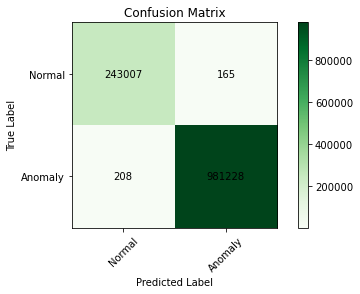

In [42]:
results = confusion_matrix(true_labels, pred_labels) 

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


plot_confusion_matrix(results, ['Normal','Anomaly'])

From the confusion matrix we can see that our model is performing really well. It is able to classify almost all of the anomalies. And this is without any tuning of XGBoost. We can see why XGBoost is so popular

The AUC curve is a plot of the True Positive Rate (TPR) against the False Positive Rate (FPR). The TPR is a measure of how often the prediction is correct, when there is a positive value, and the FPR is how often the prediction is incorrect when the value is in fact negative.

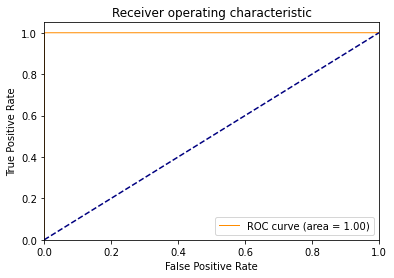

In [43]:
fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, pred_labels)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

The closer the curve is to the left-hand and the top-hand borders of the ROC plotting area, the better the model is performing over all thresholds. The area under the ROC curve (AUC) is a way of quantifying this performance. 1 is a perfect score.

*Model Inspection* Why is our model performing so well? One tool we can use from XGBoost is the feature importance. XGBoost will rank the features that it uses in determining a classification. We can visualize the feature importance using the "plot_importance" method.
Knowing which features are contributing the model can be really useful for solving business problems. In the case of network security, those features can give us way to possibly preempt malicious activity.
Feature importance can also be a great way to debug your model.
You might have to run this cell twice to see the feature importance.

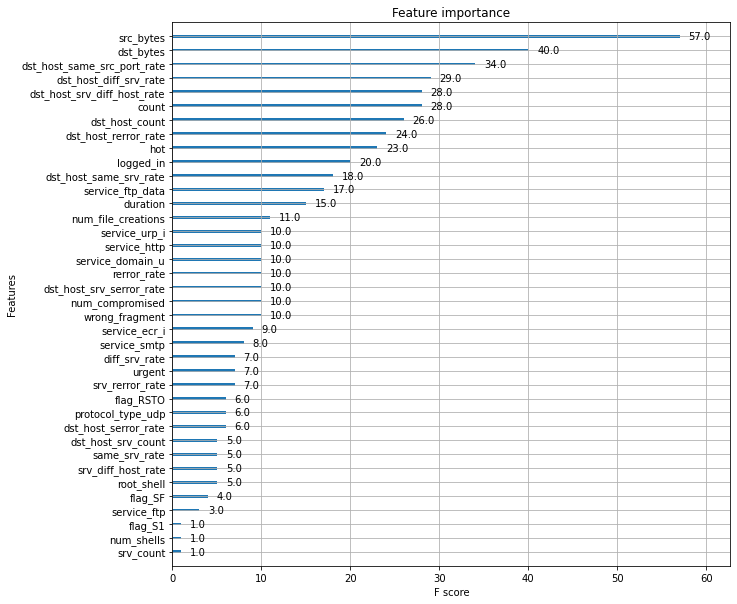

In [44]:
ax = xgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(10, 10)

${\textbf{Extreme Gradient Boosting (XGBoost) : Multi-Class classification}}$

We've seen that XGBoost can identify anomalies in the KDD99 dataset really easily. Let's see if XGBoost can detect the different types of anomalies. To do that we will train a multi-classification model.

We'll point out the difference, then have you implement the pieces that are the same using the binary classifier as a model.

For multi-classification models, the labels have to be converted to integers (we've already done this) and the 'objective ' and 'num_class' parameters must be changed accordingly.

In [45]:
num_labels = len(le.classes_)
params['objective'] = 'multi:softprob'
params['num_class'] = num_labels
print(params)

{'num_rounds': 10, 'max_depth': 8, 'max_leaves': 256, 'alpha': 0.9, 'eta': 0.1, 'gamma': 0.1, 'learning_rate': 0.1, 'subsample': 1, 'reg_lambda': 1, 'scale_pos_weight': 2, 'tree_method': 'gpu_hist', 'objective': 'multi:softprob', 'num_class': 23}


In [46]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
evals = [(dtest, 'test',), (dtrain, 'train')]
model = xgb.train(params, dtrain, evals=evals)

[13:59:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_rounds", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	test-mlogloss:2.03140	train-mlogloss:2.03139
[1]	test-mlogloss:1.66741	train-mlogloss:1.66739
[2]	test-mlogloss:1.41901	train-mlogloss:1.41899
[3]	test-mlogloss:1.22980	train-mlogloss:1.22977
[4]	test-mlogloss:1.07779	train-mlogloss:1.07774
[5]	test-mlogloss:0.95154	train-mlogloss:0.95149
[6]	test-mlogloss:0.84457	train-mlogloss:0.84452
[7]	test-mlogloss:0.75259	train-mlogloss:0.75254
[8]	test-mlogloss:0.67259	train-mlogloss:0.67253
[9]	test-mlogloss:0.60251	train-mlogloss:0.60245


In [47]:
preds = model.predict(dtest)

In [48]:
pred_labels = np.argmax(preds, axis=1)
pred_labels

array([11, 18, 11, ..., 11, 18, 18], dtype=int64)

In [49]:
true_labels = y_test
true_labels 

array([11, 18, 11, ..., 11, 18, 18])

In [50]:
print ('Accuracy Score :', accuracy_score(true_labels, pred_labels))

Accuracy Score : 0.999853830776869


Confusion Matrix :


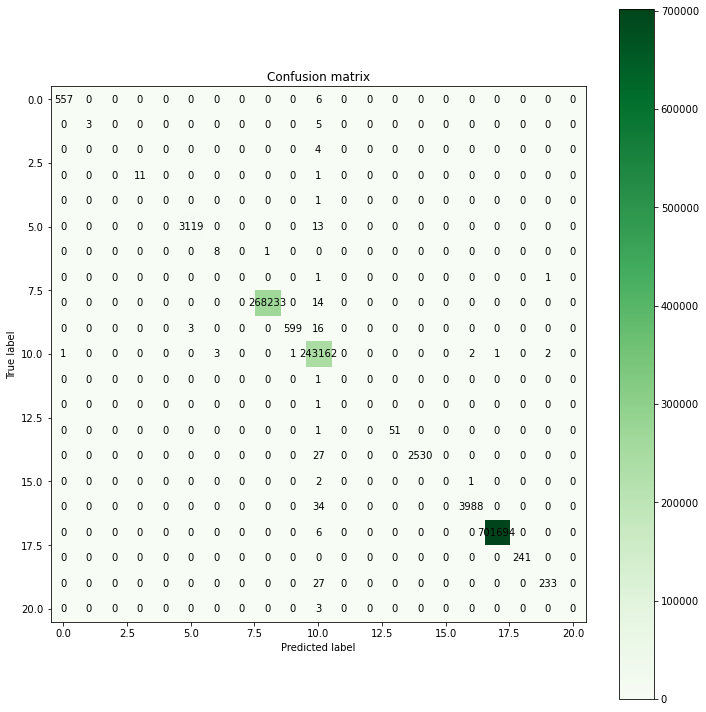

In [51]:
cm = confusion_matrix(true_labels, pred_labels)

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(10,10),)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    #tick_marks = np.arange(len(target_names))
    #plt.xticks(tick_marks, target_names, rotation=45)
    #plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)